In [ ]:
import os, torch

# Where HF will cache stuff in general (models + datasets)
os.environ["HF_HOME"] = r"D:\hf_cache"
os.makedirs(os.environ["HF_HOME"], exist_ok=True)

# Where we keep the project’s model (base + fine-tuned)
MODEL_DIR = r"D:\hf_models\SalsaSarcasm_v1"
os.makedirs(MODEL_DIR, exist_ok=True)

print("HF cache:", os.environ["HF_HOME"])
print("Model dir:", MODEL_DIR)

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

HF cache: D:\hf_cache
Model dir: D:\hf_models\SalsaSarcasm_v1
CUDA available: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

base_model_name = "FacebookAI/roberta-large"

# Download from HF hub
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=2
)

#Save to Folder
tokenizer.save_pretrained(MODEL_DIR)
model.save_pretrained(MODEL_DIR)

print("Base model downloaded and saved to:", MODEL_DIR)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model downloaded and saved to: D:\hf_models\SalsaSarcasm_v1


Loading the Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_DIR,
    local_files_only=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Loaded model from:", MODEL_DIR)


Loaded model from: D:\hf_models\SalsaSarcasm_v1


Loading the Dataset (Train)

In [ ]:
from datasets import load_dataset

dataset = load_dataset("salsabilahasna/Sarcasm_Dataset")
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['Y', 'text'],
        num_rows: 20033
    })
    test: Dataset({
        features: ['Y', 'text'],
        num_rows: 8586
    })
})


In [ ]:
print(dataset['train'][0])
print(dataset['train'].column_names)

{'Y': 1, 'text': 'thirtysomething scientists unveil doomsday clock of hair loss'}
['Y', 'text']


Preprocessing

In [ ]:
dataset = dataset.rename_column("Y", "label")

label_map = {0: "NOT_SARCASTIC", 1: "SARCASTIC"}

def add_label_text(example):
    example["label_text"] = label_map[example["label"]]
    return example

dataset = dataset.map(add_label_text)

In [ ]:
print(dataset['train'][0])
print(dataset['train'].column_names)
print(dataset['test'][0])
print(dataset['test'].column_names)

{'label': 1, 'text': 'thirtysomething scientists unveil doomsday clock of hair loss', 'label_text': 'SARCASTIC'}
['label', 'text', 'label_text']
{'label': 1, 'text': 'man wondering if there might be some sort of website featuring footage of sexual acts one may view for purposes of self gratification', 'label_text': 'SARCASTIC'}
['label', 'text', 'label_text']


In [ ]:
train_ds = dataset['train']
test_ds = dataset['test']

In [ ]:
from transformers import AutoTokenizer

# Load tokenizer from the same folder where you saved the base model
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)

MAX_LEN = 128

def tokenize_batch(batch):
    encoded = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )
    encoded["label"] = batch["label"]
    return encoded

# Apply tokenization to train and test
encoded_train = dataset["train"].map(tokenize_batch, batched=True)
encoded_test  = dataset["test"].map(tokenize_batch, batched=True)

# Convert to torch tensors for PyTorch training
cols = ["input_ids", "attention_mask", "label"]
encoded_train.set_format(type="torch", columns=cols)
encoded_test.set_format(type="torch", columns=cols)

In [ ]:
print(encoded_train[0])
print(encoded_test[0])

{'label': tensor(1), 'input_ids': tensor([    0,   212, 32430, 18891,  4211, 18834,   109, 41334,  6700,     9,
         2549,   872,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,  

Training Parameters

Spliting the train data for pytorch

In [ ]:
train_val = encoded_train.train_test_split(test_size=0.1, seed=42)

train_ds = train_val["train"]
val_ds   = train_val["test"]
test_ds  = encoded_test    # Redefined


Metrics for updates

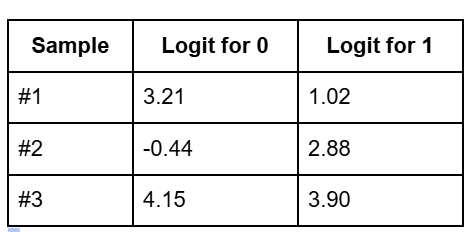

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=MODEL_DIR,  # where to save model/checkpoints
    num_train_epochs=3,  # Based on research 3 is a good starting point and more epoch mean longer time to train
    learning_rate=2e-5,  # stable learning rate for large transformer models
    per_device_train_batch_size=8,  # good size for my laptop vram
    per_device_eval_batch_size=16,  # decent batch
    warmup_ratio=0.1,  # warm up 10% to avoid early instability
    weight_decay=0.01,  # regularization to reduce overfitting , used by most research paper
    eval_strategy="epoch",  # evaluate after each epoch
    save_strategy="epoch",  # save checkpoint every epoch
    logging_steps=50,  # log training progress
    load_best_model_at_end=True,  # automatically load best F1 model
    metric_for_best_model="f1",  # F1 is best metric for sarcasm detection
    greater_is_better=True,  # higher F1 is better
    fp16=True,  # faster training
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.304500,0.339164,0.897705,0.878543,0.910808,0.894384
2,0.203900,0.456650,0.919661,0.896000,0.940189,0.917563
3,0.106300,0.459820,0.927645,0.936285,0.909759,0.922831


TrainOutput(global_step=6762, training_loss=0.275485634038275, metrics={'train_runtime': 1695.2629, 'train_samples_per_second': 31.905, 'train_steps_per_second': 3.989, 'total_flos': 1.2601342912080384e+16, 'train_loss': 0.275485634038275, 'epoch': 3.0})

In [ ]:
MODEL_DIR = r"D:\hf_models\Finetuned_Salsa"
trainer.save_model(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)

print("Fine-tuned model saved to:", MODEL_DIR)

Fine-tuned model saved to: D:\hf_models\Finetuned_Salsa


Testing

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_DIR,
    local_files_only=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Loaded model from:", MODEL_DIR)

Loaded model from: D:\hf_models\Finetuned_Salsa


In [ ]:
print(" FINAL TEST METRICS ")
test_results = trainer.evaluate(test_ds)
print(test_results)


 FINAL TEST METRICS 


{'eval_loss': 0.4044016897678375, 'eval_accuracy': 0.9320987654320988, 'eval_precision': 0.9470723600102275, 'eval_recall': 0.907843137254902, 'eval_f1': 0.9270429232886997, 'eval_runtime': 29.838, 'eval_samples_per_second': 287.754, 'eval_steps_per_second': 17.997, 'epoch': 3.0}


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

pred_output = trainer.predict(test_ds) # Run the model on Test_ds
logits = pred_output.predictions # A logit is the raw output of a neural network before converting it into a probability.
preds = np.argmax(logits, axis=-1) # Picking the higher logit to determine 1 or 0 and axis = -1 mean you pick the classes
labels = test_ds["label"]

print("\n  CLASSIFICATION REPORT  ")
print(classification_report(labels, preds, target_names=["NOT_SARCASTIC", "SARCASTIC"]))

cm = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(
    cm,
    index=["TRUE_NOT_SARC", "TRUE_SARC"],
    columns=["PRED_NOT_SARC", "PRED_SARC"]
)

print("\n  CONFUSION MATRIX  ")
print(df_cm)



  CLASSIFICATION REPORT  
               precision    recall  f1-score   support

NOT_SARCASTIC       0.92      0.95      0.94      4506
    SARCASTIC       0.95      0.91      0.93      4080

     accuracy                           0.93      8586
    macro avg       0.93      0.93      0.93      8586
 weighted avg       0.93      0.93      0.93      8586


  CONFUSION MATRIX  
               PRED_NOT_SARC  PRED_SARC
TRUE_NOT_SARC           4299        207
TRUE_SARC                376       3704


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(labels, preds):
    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)

    # Normalize by true class (row-wise)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Create labels with counts and percentages
    labels_text = np.array([
        [f"{cm[i, j]}\n({cm_norm[i, j]*100:.1f}%)" for j in range(cm.shape[1])]
        for i in range(cm.shape[0])
    ])

    plt.figure(figsize=(8, 6))
    sns.set(style="white")

    ax = sns.heatmap(
        cm_norm,
        annot=labels_text,
        fmt="",
        cmap="Blues",
        cbar_kws={"label": "Proportion"},
        xticklabels=["Not Sarcastic (0)", "Sarcastic (1)"],
        yticklabels=["Not Sarcastic (0)", "Sarcastic (1)"],
        linewidths=0.5,
        linecolor="gray"
    )

    plt.title("Confusion Matrix (Normalized by True Class)", fontsize=16)
    plt.xlabel("Predicted label", fontsize=14)
    plt.ylabel("True label", fontsize=14)
    plt.tight_layout()
    plt.show()


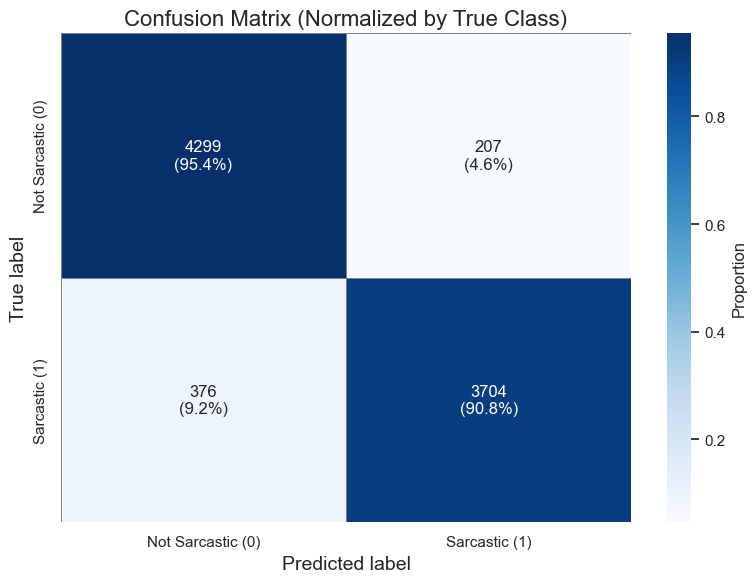

In [ ]:
pred_output = trainer.predict(test_ds)
logits = pred_output.predictions
preds = np.argmax(logits, axis=-1)
labels = test_ds["label"]

plot_confusion_matrix(labels, preds)


In [ ]:
import torch

id2label = {0: "NOT_SARCASTIC", 1: "SARCASTIC"}

def predict_text(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    ).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=-1).item()

    return id2label[pred]


In [ ]:
print(predict_text("New york introduces shoe sharing program for city pedestrians"))
print(predict_text("I really enjoy calm sunny mornings"))


SARCASTIC
NOT_SARCASTIC
